# Notebook 2 - Modelling of data derived from network analysis of metabolomic measurements from plasma samples from COVID patients. 

#### This notebook is a part of a project with the Center for Systems Biology at the University of Iceland. The goal here is to:

1. Take the results from a correlation network analysis of the untargeted metabolomic measurements of the plasma samples (which includes the module eigenvectors and the assignment of features into different modules) along with the original metabolomic dataframe and the clinical data, and create a model that is able to predict the composite outcome of the patients. 

2. After finding the modules that are most important for the prediction of composite outcomes, we look into these modules, what metabolic pathways they represent and what features are most representative of them. 

3. The most representative features (who have now been putatively annotated) are tried out as predictors of composite outcome. The results of that feature selection-based model is then compared to a model based on all >5000 features present in the untargeted metabolomic measurement. 

## Import modules:

In [2]:
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold

## Define functions

In [3]:
def impute_df(dataframe):
    '''
    A function to impute dataframe using KNN while still keeping the dataframe structure
    '''
    dat_columns = dataframe.columns
    dat_index = dataframe.index.tolist()
    imputah = KNNImputer()
    scalah = StandardScaler()
    dat_scaled = scalah.fit_transform(dataframe)
    dat_imputed = imputah.fit_transform(dat_scaled)
    dat_orig_transformed = scalah.inverse_transform(dat_imputed)
    return_df = pd.DataFrame(dat_orig_transformed, columns = dat_columns,index = dat_index)
    return return_df

def remove_columns_with_missing_data(dataframe,threshold_percentage):
    '''
    A function to remove columns from a dataframe that have more than threshold_percentage missing values
    '''
    # First remove rows that have NaN for all values:
    threshold_ = int(dataframe.shape[0]*(threshold_percentage/100))
    idx_remove = []
    for column_val in dataframe.columns:
        if dataframe[column_val].isna().sum() > threshold_:
            idx_remove.append(column_val)
    df_out = dataframe.drop(idx_remove, axis=1)
    return df_out

def indices(lst, element):
    result = []
    offset = -1
    while True:
        try:
            offset = lst.index(element, offset+1)
        except ValueError:
            return result
        result.append(offset)

## Load data and make some adjustments to the clinical data:

In [4]:
mes = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/MEs_dataframe_15SEP2022.csv')
patients = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/patients_vector_15SEP2022.csv')
clin = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/Database.csv',sep =';')
id_present = [idxx_ for idxx_,x in enumerate(clin['Subject Identifier for the Study'].tolist()) if x in patients['x'].tolist()]
clin = clin.iloc[id_present,:]
clin = clin.reset_index()

# Begin by getting only the clinical data with the non-outlier patient samples from the metabolomics network analysis: 
clin['sex_binary'] = clin['Sex']
clin['sex_binary'].replace('Male', 0,inplace=True)
clin['sex_binary'].replace('Female', 1,inplace=True)
clin['HTN_binary'] = clin['HTN']
clin['HTN_binary'].replace('Yes', 1,inplace=True)
clin['HTN_binary'].replace('No', 0,inplace=True)
clin['diabetes_binary'] = clin['Diabetes']
clin['diabetes_binary'].replace('Yes', 1,inplace=True)
clin['diabetes_binary'].replace('No', 0,inplace=True)
clin = clin.loc[:, clin.columns != 'Sex']
clin = clin.loc[:, clin.columns != 'HTN']
clin = clin.loc[:, clin.columns != 'Diabetes']

typess = clin.dtypes
for column_val in clin.columns[6:]:
    if typess[column_val] == 'O':
        clin[column_val] = clin[column_val].str.replace(',','.')
        clin[column_val] = pd.to_numeric(clin[column_val], errors='coerce')

# Remove clinical data with more than 10% missing data:
clin = remove_columns_with_missing_data(clin,10) 

# Select appropriate variables to keep in data:
clin_orig = clin.copy()
clin = clin[['sex_binary','BMI','Composite']]
clin = impute_df(clin)
clin_orig = impute_df(clin_orig)

# Set response variable as integer:
clin['Composite'] = clin['Composite'].astype(int)
clin_orig['Composite'] = clin_orig['Composite'].astype(int)

# Load data from the network analysis in R:
mergedcolors = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/module_assignments_15SEP2022.csv')
findat = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/Final_dataframe_15SEP2022.csv')
datkme = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/datkme_15SEP2022.csv')

## Split data into train and test sets:

In [5]:
new_mes = pd.concat([mes,clin.loc[:, clin.columns != 'Composite']],axis = 1)
X = new_mes
y = clin['Composite']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,random_state=10)

# Create clinical train and test data (for later modeling):
clin_train = clin.iloc[y_train.index.tolist(),:]
clin_test = clin.iloc[y_test.index.tolist(),:]

# Create final train and test data (for later modeling):
findat_train = findat.iloc[y_train.index.tolist(),:]
findat_test = findat.iloc[y_test.index.tolist(),:]

## Try out penalized logistic regression (LASSO):

In [6]:
# Setup the parameters for the logistic regression model:
param_grid = {'penalty': ['l1'], 'solver': ['saga'],'max_iter': [10000]}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5) # specify the classifier, parameter grid, and number of folds to use.

# Fit it to the data
logreg_cv.fit(X_train.values, y_train.values)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}
Tuned Logistic Regression Accuracy: 0.7153846153846153


## Try out random forest (RF):

In [7]:
# Create a random forest classifier
rf_clf = RandomForestClassifier()

# Try out a grid of parameters:
parameters = {'max_features':np.arange(2,4),'n_estimators':[1000,2000],'max_depth':[2,3,4], 'random_state':[0]}

# Setup the gridsearch and fit the model to the training data:
clf = GridSearchCV(rf_clf, parameters, cv = 5)
clf.fit(X_train.values,y_train.values)
feat_labels = new_mes.columns.tolist()

# Save the best parameters for later:
params_best = clf.best_estimator_.get_params()

## Select most important variables from RF model (Gini importance):

In [8]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than some threshold value: 
sfm = SelectFromModel(clf.best_estimator_, threshold=0.057)

# Train the selector
sfm.fit(X_train.values, y_train.values)

# Print the names of the most important features
features = []
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])
    features.append(feat_labels[feature_list_index])
    
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train.values)
X_important_test = sfm.transform(X_test.values)

MEdarkolivegreen
MEred


## Compare accuracy of full RF model (based on all modules) and a RF model based on most important modules:

In [9]:
# Create a new random forest classifier for the most important features, with the same parameters as were shown to perform best
# in the previous cell:
clf_important = RandomForestClassifier(**params_best)

# Apply The Full Featured Classifier To The Test Data
y_pred = clf.best_estimator_.predict(X_test.values)

# View The Accuracy Of Our Full Feature Model
print('Accuracy for full RF model: ',accuracy_score(y_test.values, y_pred))

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train.values)

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (2 Features) Model
print('Accuracy for important-module RF model :',accuracy_score(y_test.values, y_important_pred))

Accuracy for full RF model:  0.4375
Accuracy for important-module RF model : 0.65625


## Now look at the ROC curves for prediction of composite outcome from the 1) Full l1-penalised logistic regression model, 2) Full RF model and 3) The important module RF model

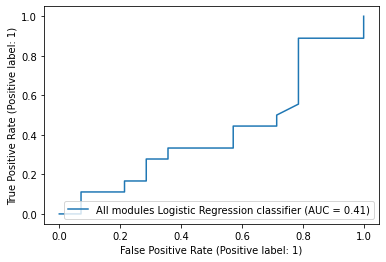

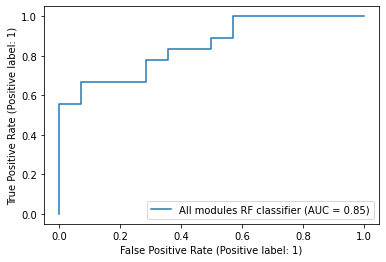

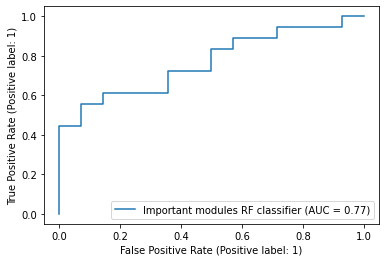

In [10]:
RocCurveDisplay.from_estimator(logreg_cv.best_estimator_, X_test.values, y_test.values, name = 'All modules Logistic Regression classifier')
RocCurveDisplay.from_estimator(clf.best_estimator_, X_test.values, y_test.values, name = 'All modules RF classifier')
RocCurveDisplay.from_estimator(clf_important, X_important_test, y_test.values,name = 'Important modules RF classifier')
plt.show()

## Plot the eigenvector values of the most important modules, stratified by the composite outcome of the patients. Also print their p-value (fraction of features belonging to that particular module):

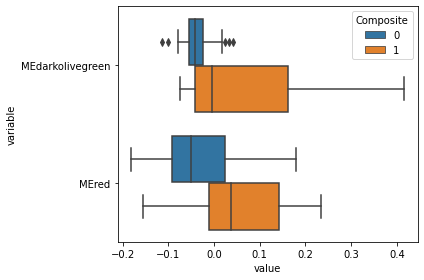

p-value threshold for  MEdarkolivegreen  is  0.0102
p-value threshold for  MEred  is  0.0272


In [11]:
df = pd.concat([clin['Composite'],new_mes[features]],axis = 1)
df_long = df.melt(id_vars=['Composite'])
ax = sns.boxplot(data=df_long, x="value", y="variable", orient="h", hue="Composite")
plt.tight_layout()
plt.show()

# To get the p-value threshold for the modules of interest:
for module in features:
    tmp_val = round(mergedcolors['x'].value_counts()[module[2:]]/len(mergedcolors),4)
    print('p-value threshold for ',module,' is ',tmp_val)

## Before moving further, the modules need to be annotated (using MetaboAnalyst). To prepare the modules for annotation, there is an R script which generates a .csv file that can be uploaded directly to MetaboAnalyst

#### This will result in a particular feature being selected for each important module. The following procedure requires them to be selected beforehand. 

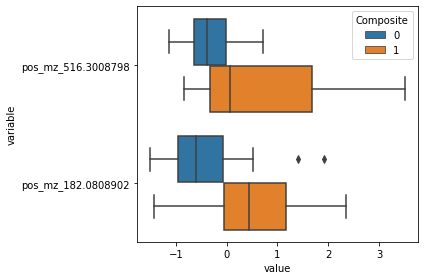

2544    darkolivegreen
1934               red
Name: x, dtype: object


In [14]:
my_top_feature = ['pos_mz_516.3008','pos_mz_182.0808'] # Taurocholic acid and Tyrosine according to MetaboAnalyst

# Find their location in the original dataframe to move forward with modeling:
findat_shortnames = [x[:15] for x in findat.columns.tolist()]

my_top_feature_id = []
for feature in my_top_feature:
    my_top_feature_id.append(indices(findat_shortnames,feature)[0])
    
new_df = pd.concat([findat_test.iloc[:,my_top_feature_id],clin['Composite']],axis = 1)
#ax = sns.boxplot(x="Critical", y=findat.columns[my_top_feature_id][0], data=new_df)
new_df_long = new_df.melt(id_vars=['Composite'])
ax = sns.boxplot(data=new_df_long, x="value", y="variable", orient="h", hue="Composite")
plt.tight_layout()
plt.show()

# Check which module the features in the above plot belong to (SANITY CHECK):
print(mergedcolors['x'][my_top_feature_id])

## Use a grid-search to search for optimal parameters for each model, then run the 5-fold CV to get an estimate of predictive capabilities of top features vs all features

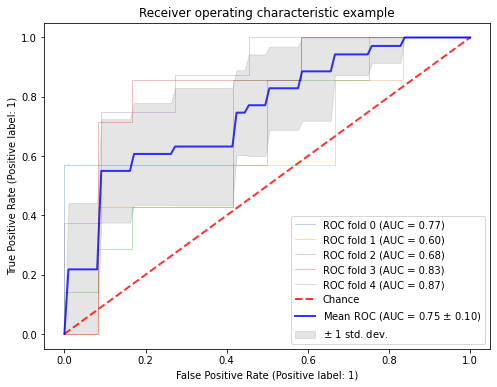

In [15]:
# Run classifier with cross-validation and plot ROC curves
X_to_use = np.array(findat.iloc[:,my_top_feature_id])
y_to_use = y.values

classifier = RandomForestClassifier()
# Try out a grid of parameters:
parameters = {'max_features':np.arange(2,4),'n_estimators':[1000,2000],'max_depth':[2,3,4], 'random_state':[0]}
classifier_opt = GridSearchCV(classifier, parameters, cv = 5)

# Fit on entire dataset to get optimal parameters:
classifier_opt.fit(X_to_use,y_to_use)
params_to_use = classifier_opt.best_estimator_.get_params()

cv = StratifiedKFold(n_splits=5)
classifier_for_cv = RandomForestClassifier(**params_to_use)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8,6))
for i, (train, test) in enumerate(cv.split(X_to_use, y_to_use)):
    classifier_for_cv.fit(X_to_use[train], y_to_use[train])
    viz = RocCurveDisplay.from_estimator(
        classifier_for_cv,
        X_to_use[test],
        y_to_use[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

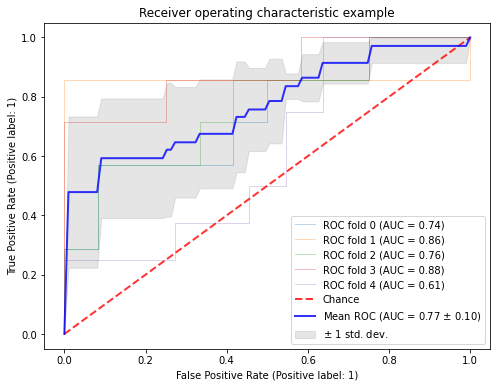

In [16]:
# Run classifier with cross-validation and plot ROC curves
X_to_use = np.array(findat)
y_to_use = y.values

classifier = RandomForestClassifier()
# Try out a grid of parameters:
parameters = {'max_features':np.arange(2,4),'n_estimators':[1000,2000],'max_depth':[2,3,4], 'random_state':[0]}
classifier_opt = GridSearchCV(classifier, parameters, cv = 5)

# Fit on entire dataset to get optimal parameters:
classifier_opt.fit(X_to_use,y_to_use)
params_to_use = classifier_opt.best_estimator_.get_params()

cv = StratifiedKFold(n_splits=5)
classifier_for_cv = RandomForestClassifier(**params_to_use)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8,6))
for i, (train, test) in enumerate(cv.split(X_to_use, y_to_use)):
    classifier_for_cv.fit(X_to_use[train], y_to_use[train])
    viz = RocCurveDisplay.from_estimator(
        classifier_for_cv,
        X_to_use[test],
        y_to_use[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()